# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je 22. 4. 2024, 23:59:59**, pokud odevzdáte úkol do 29. 4. 2024, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [22]:
### odtud už je to Vaše

import pandas as pd
import numpy as np


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, ParameterGrid
import sklearn.metrics as metrics

import matplotlib.pyplot as plt

rd_seed=666



Load the train.cvs dataset and show it contains:

In [23]:
data = pd.read_csv('train.csv')
print(data.head())
data.info()

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      0       0       0       0       0       0       0       0       0   
4      1       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...       208       122         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       1  ...        75        11         0         1         0         0   
3       0  ...       106       103        76         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

Extract the "label" column to a target vector Y and split into train, val, test subsets:

In [24]:
Xdata = data.drop('label', axis = 1)
ydata = data.label
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.4, random_state=rd_seed) 
Xtest, Xval, ytest, yval = train_test_split (Xtest,ytest, test_size= 0.5, random_state=rd_seed)

Research some info about the dataset

In [25]:
#As we can see, the target vector may have only 0 or 1 as it's value and the count of each value is generally even
print( ydata.value_counts() )
#There's 2400 images 28*28 pixels
print( data.count(axis=1) )

label
0    1238
1    1162
Name: count, dtype: int64
0       785
1       785
2       785
3       785
4       785
       ... 
2395    785
2396    785
2397    785
2398    785
2399    785
Length: 2400, dtype: int64


Pick 5 random pictures from the dataset and print them:

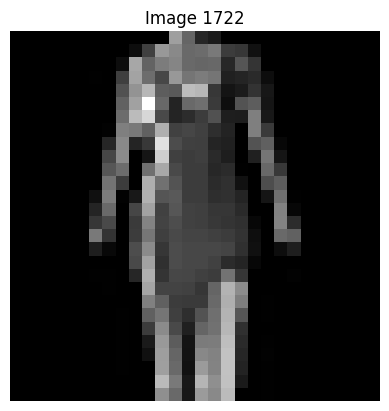

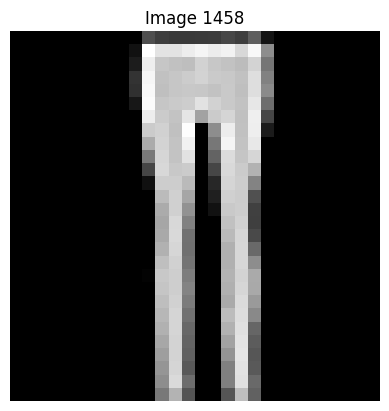

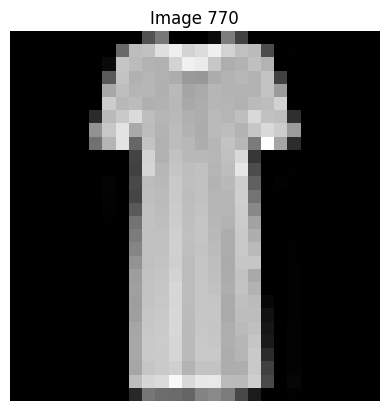

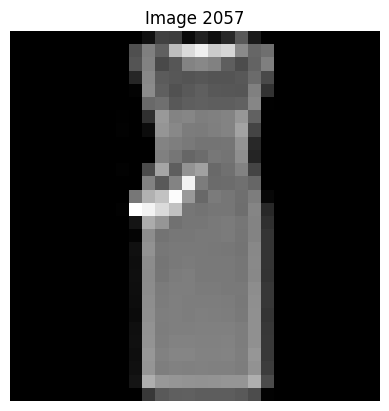

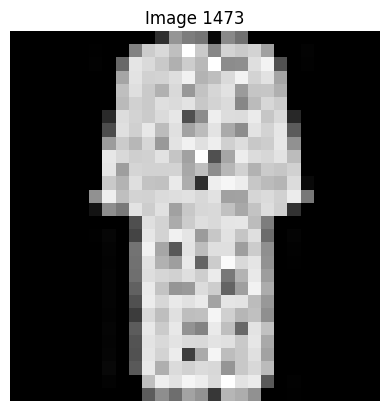

In [26]:
random_rows = Xdata.sample(n=5)

for index, row in random_rows.iterrows():
    row_data = row.values

    image = np.array(row_data).reshape(28, 28)

    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Hide axes
    plt.title(f"Image {index}")
    plt.show()

As we can see pictures tend to have "blank" black corners and side edges, so we could reduce the amount of parameters later

create scaled data:

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# use standard scaler
SS = StandardScaler().fit(Xtrain)
Xtrain_SS = SS.transform(Xtrain)
Xval_SS = SS.transform(Xval)
Xtest_SS = SS.transform(Xtest)
# use MinMax scaler
MMS = MinMaxScaler().fit(Xtrain)
Xtrain_MMS = MMS.transform(Xtrain)
Xval_MMS = MMS.transform(Xval)
Xtest_MMS = MMS.transform(Xtest)

SVM model:

In [95]:
from sklearn.svm import SVC
#create the parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': range (2,10,2),
    'C': np.arange(0.1, 2.0, 0.2)
}
#find the best parameters
param_comb = ParameterGrid(param_grid)
val_metric = []
for params in param_comb:
    clfSVC = SVC(**params)
    clfSVC.fit(Xtrain,ytrain)
    val_metric.append(clfSVC.score(Xval, yval))
    



In [101]:
best_params_SVC = param_comb[np.argmax(val_metric)]
clfSVC_fc = SVC(**best_params_SVC)
clfSVC_fc.fit(Xtrain,ytrain)
print(f"We found the best params {best_params_SVC} with accuracy score {max(val_metric):.5f}.")

We found the best params {'kernel': 'poly', 'degree': 2, 'C': 1.1000000000000003} with accuracy score 0.98125.


Try find the best parameters for scaled data:

In [97]:
param_comb = ParameterGrid(param_grid)
val_metric_SS = []
for params in param_comb:
    clfSVC = SVC(**params)
    clfSVC.fit(Xtrain_SS,ytrain)
    val_metric_SS.append(clfSVC.score(Xval_SS, yval))

In [98]:
best_params_SWC_SS = param_comb[np.argmax(val_metric_SS)]
clfSWC_fc_SS = SVC(**best_params_SVC)
clfSWC_fc_SS.fit(Xtrain_SS,ytrain)
print(f"We found the best params {best_params_SWC_SS} with accuracy score {max(val_metric_SS):.5f}.")

We found the best params {'kernel': 'rbf', 'degree': 2, 'C': 0.9000000000000001} with accuracy score 0.97917.


As we can see, accuracy score got worse using Standard scaler, now try doing the same step with MMS scaler:

In [99]:
param_comb = ParameterGrid(param_grid)
val_metric_MMS = []
for params in param_comb:
    clfSVC = SVC(**params)
    clfSVC.fit(Xtrain_MMS,ytrain)
    val_metric_MMS.append(clfSVC.score(Xval_MMS, yval))

In [100]:
best_params_SVC_MMS = param_comb[np.argmax(val_metric_MMS)]
clfSVC_fc_MMS = SVC(**best_params_SVC)
clfSVC_fc_MMS.fit(Xtrain_MMS,ytrain)
print(f"We found the best params {best_params_SVC_MMS} with accuracy score {max(val_metric_MMS):.5f}.")

We found the best params {'kernel': 'linear', 'degree': 2, 'C': 0.1} with accuracy score 0.98125.


MMS scaler has the same accuracy score as non-scaled data

Train a naive bayes model:

Scaling is unlikely to improve the perfomance of NB

In [35]:
# Try GaussianNB:
from sklearn.naive_bayes import GaussianNB

clf_GNB = GaussianNB();
clf_GNB.fit(Xtrain, ytrain);
print(f"Train data accuracy is {clf_GNB.score(Xtrain, ytrain):.4f}")

print(f"Val data accuracy is {clf_GNB.score(Xval, yval):.4f}")
ypred = clf_GNB.predict(Xval)
print(f"\nFrom {Xval.shape[0]} point in Xval were classified wrong: {(yval != ypred).sum()}")

Train data accuracy is 0.9174
Val data accuracy is 0.9146

From 480 point in Xval were classified wrong: 41


In [36]:
# Try BernoulliNB:
from sklearn.naive_bayes import BernoulliNB

clf_BNB = BernoulliNB();
clf_BNB.fit(Xtrain, ytrain);
print(f"Train data accuracy is {clf_BNB.score(Xtrain, ytrain):.4f}")

print(f"Val data accuracy is {clf_BNB.score(Xval, yval):.4f}")
ypred = clf_BNB.predict(Xval)
print(f"\nFrom {Xval.shape[0]} point in Xval were classified wrong: {(yval != ypred).sum()}")

Train data accuracy is 0.9340
Val data accuracy is 0.9417

From 480 point in Xval were classified wrong: 28


In [37]:
from sklearn.naive_bayes import MultinomialNB

clf_MNB = MultinomialNB()
clf_MNB.fit(Xtrain, ytrain);
print(f"Train data accuracy is {clf_MNB.score(Xtrain, ytrain):.4f}")

print(f"Val data accuracy is {clf_MNB.score(Xval, yval):.4f}")
ypred = clf_MNB.predict(Xval)
print(f"\nFrom {Xval.shape[0]} point in Xval were classified wrong: {(yval != ypred).sum()}")

Train data accuracy is 0.9361
Val data accuracy is 0.9500

From 480 point in Xval were classified wrong: 24


As we can see, MultinomialNB has significantly better prediction accuracy than GaussianNB with less wrong classifications and slightly better prediction accuracy than BernoulliNB, but worse accuracy than SVM method 

Now try LDA model:

In [102]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#create the parameter grid
param_grid_lda = {
    'solver': ['svd', 'lsqr'],
    'store_covariance': [True, False],
    'shrinkage': [None, 'auto', 0.1, 0.3, 0.5, 0.7, 0.9],
    'priors': [None, [0.1, 0.9], [0.5, 0.5], [0.9, 0.1]],
}
#find the best parameters
param_comb = ParameterGrid(param_grid_lda)
val_metric_lda = []
for params in param_comb:
    if params['solver'] == 'svd':
        params.pop('shrinkage', None)
    clfLDA = LinearDiscriminantAnalysis(**params)
    clfLDA.fit(Xtrain,ytrain)
    val_metric_lda.append(clfLDA.score(Xval, yval))

In [104]:
best_params_LDA = param_comb[np.argmax(val_metric_lda)]
clfLDA_fc = LinearDiscriminantAnalysis(**best_params_LDA)
clfLDA_fc.fit(Xtrain,ytrain)
print(f"We found the best params {best_params_LDA} with accuracy score {max(val_metric_lda):.5f}.")

We found the best params {'store_covariance': True, 'solver': 'lsqr', 'shrinkage': 'auto', 'priors': None} with accuracy score 0.97708.


Find the best LDA parameters for scaled data

In [105]:
# standard scaler
param_comb = ParameterGrid(param_grid_lda)
val_metric_lda_SS = []
for params in param_comb:
    if params['solver'] == 'svd':
        params.pop('shrinkage', None)
    clfLDA = LinearDiscriminantAnalysis(**params)
    clfLDA.fit(Xtrain_SS,ytrain)
    val_metric_lda_SS.append(clfLDA.score(Xval_SS, yval))

In [106]:
best_params_LDA_SS = param_comb[np.argmax(val_metric_lda_SS)]
clfLDA_fc_SS = LinearDiscriminantAnalysis(**best_params_LDA_SS)
clfLDA_fc_SS.fit(Xtrain_SS,ytrain)
print(f"We found the best params {best_params_LDA_SS} with accuracy score {max(val_metric_lda_SS):.5f}.")

We found the best params {'store_covariance': True, 'solver': 'lsqr', 'shrinkage': 'auto', 'priors': None} with accuracy score 0.97500.


In [42]:
# MMS scaler
val_metric_lda_MMS = []
for params in param_comb:
    if params['solver'] == 'svd':
        params.pop('shrinkage', None)
    clfLDA = LinearDiscriminantAnalysis(**params)
    clfLDA.fit(Xtrain_MMS,ytrain)
    val_metric_lda_MMS.append(metrics.accuracy_score(yval, clfLDA.predict(Xval_MMS)))

In [43]:
best_params_LDA_MMS = param_comb[np.argmax(val_metric_lda_MMS)]
clfLDA_fc_MMS = LinearDiscriminantAnalysis(**best_params_LDA_MMS)
clfLDA_fc_MMS.fit(Xtrain_MMS,ytrain)
print(f"We found the best params {best_params_LDA_MMS} with accuracy score {max(val_metric_lda_MMS):.5f}.")

We found the best params {'store_covariance': True, 'solver': 'lsqr', 'shrinkage': 0.3, 'priors': None} with accuracy score 0.97708.


Again, unscaled data got the best accuracy score as well as MMS scaled data

Applicate PCA method to given data

for SVM:

In [44]:
from sklearn.decomposition import PCA

best_accuracy = 0.0
best_n_components = None
clfSVC_pca = SVC(**best_params_SVC)

for n in range(1, 28*28, 5):
    pca = PCA(n_components=n)
    Xtrain_pca = pca.fit_transform(Xtrain)
    Xval_pca = pca.transform(Xval)
    # choose the best hyperparameters found for uncompressed data
    clfSVC_pca.fit(Xtrain_pca, ytrain)
    val_accuracy = metrics.accuracy_score(yval, clfSVC_pca.predict(Xval_pca))
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params
        best_n_components = n   

print("Best Number of Components:", best_n_components)
print("Best Accuracy:", best_accuracy)


Best Number of Components: 51
Best Accuracy: 0.96875


In [45]:
from sklearn.decomposition import PCA
# for a normal scaler
best_accuracy = 0.0
best_n_components = None
clfSVC_pca_SS = SVC(**best_params_SVC)

for n in range(1, 28*28, 5):
    pca = PCA(n_components=n)
    Xtrain_pca_SS = pca.fit_transform(Xtrain_SS)
    Xval_pca_SS = pca.transform(Xval_SS)
    # choose the best hyperparameters found for uncompressed data
    clfSVC_pca_SS.fit(Xtrain_pca_SS, ytrain)
    val_accuracy = metrics.accuracy_score(yval, clfSVC_pca_SS.predict(Xval_pca_SS))
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params
        best_n_components = n   

print("Best Number of Components:", best_n_components)
print("Best Accuracy:", best_accuracy)


Best Number of Components: 91
Best Accuracy: 0.9520833333333333


SVM with LLE:

In [46]:
from sklearn.manifold import LocallyLinearEmbedding

param_grid_lle = {
    'n_neighbors': range(2,50,5),
    'n_components': range(1,50,5),
    'eigen_solver':  ['dense']
}
clfSVC_lle = SVC(**best_params_SVC)
#find the best parameters for LLE
param_comb = ParameterGrid(param_grid_lle)
val_metric_lle = []
for params in param_comb:
    lle = LocallyLinearEmbedding(**params)
    Xtrain_lle = lle.fit_transform(Xtrain)
    Xval_lle = lle.fit_transform(Xval)
    clfSVC_lle.fit(Xtrain_lle,ytrain)
    val_metric_lle.append(metrics.accuracy_score(yval, clfSVC_lle.predict(Xval_lle)))

In [47]:
best_params_SVC_lle = param_comb[np.argmax(val_metric_lle)]
lle_fc = LocallyLinearEmbedding(**best_params_SVC_lle)
clfSVC_lle_fc = SVC(**best_params_SVC)
Xtrain_lle = lle_fc.fit_transform(Xtrain)
clfSVC_lle_fc.fit(Xtrain_lle, ytrain)
print(f"We found the best params {best_params_SVC_lle} with accuracy score {max(val_metric_lle):.5f}.")

We found the best params {'n_neighbors': 22, 'n_components': 6, 'eigen_solver': 'dense'} with accuracy score 0.83333.


In [48]:
# using normal scaler

In [49]:
clfSVC_lle = SVC(**best_params_SVC)
#find the best parameters for LLE
param_comb = ParameterGrid(param_grid_lle)
val_metric_lle_SS = []
clfSVC_lle_SS = SVC(**best_params_SVC)
for params in param_comb:
    lle = LocallyLinearEmbedding(**params)
    Xtrain_lle_SS = lle.fit_transform(Xtrain_SS)
    Xval_lle_SS = lle.fit_transform(Xval_SS)
    clfSVC_lle_SS.fit(Xtrain_lle_SS,ytrain)
    val_metric_lle_SS.append(metrics.accuracy_score(yval, clfSVC_lle_SS.predict(Xval_lle_SS)))

In [50]:
best_params_SVC_lle_SS = param_comb[np.argmax(val_metric_lle_SS)]
lle_SS_fc = LocallyLinearEmbedding(**best_params_SVC_lle)
clfSVC_lle_SS_fc = SVC(**best_params_SVC)
Xtrain_lle_SS = lle_SS_fc.fit_transform(Xtrain)
clfSVC_lle_SS_fc.fit(Xtrain_lle_SS, ytrain)
print(f"We found the best params {best_params_SVC_lle_SS} with accuracy score {max(val_metric_lle_SS):.5f}.")

We found the best params {'n_neighbors': 2, 'n_components': 16, 'eigen_solver': 'dense'} with accuracy score 0.80833.


Yet again, unscaled data has better prediction accuracy,but both LLE and PCA haven't improved prediction accuracy in comparison to a simple SVC

Now try applying both PCA and LLE to Naive Bayes model:

In [55]:
# Gaussian With PCA
clf_GNB_PCA = GaussianNB();
best_accuracy_GNB = 0.0
best_n_components_GNB = None
for n in range(1, 28*28, 5):
    pca = PCA(n_components=n)
    Xtrain_pca = pca.fit_transform(Xtrain)
    Xval_pca = pca.transform(Xval)
    clf_GNB_PCA.fit(Xtrain_pca, ytrain);
    val_accuracy =  clf_GNB_PCA.score(Xval_pca, yval)
    if val_accuracy > best_accuracy_GNB:
        best_accuracy_GNB = val_accuracy
        best_n_components_GNB = n   



In [56]:
pca = PCA( n_components = best_n_components_GNB )
Xtrain_pca = pca.fit_transform(Xtrain)
Xval_pca = pca.transform(Xval)
clf_GNB_PCA_fc =  GaussianNB()
clf_GNB_PCA_fc.fit(Xtrain_pca, ytrain);
print(f"Best n_components number is {best_n_components} with val accuracy score: {clf_GNB_PCA_fc.score(Xval_pca, yval):.4f}")

ypred =  clf_GNB_PCA_fc.predict(Xval_pca)
print(f"\nFrom {Xval_pca.shape[0]} point in Xval were classified wrong: {(yval != ypred).sum()}")

Best n_components number is 91 with val accuracy score: 0.9583

From 480 point in Xval were classified wrong: 20


In [59]:
# Gaussian With PCA on scaled data
clf_GNB_PCA = GaussianNB();
best_accuracy_GNB_SS = 0.0
best_n_components_GNB_SS = None
for n in range(1, 28*28, 5):
    pca = PCA(n_components=n)
    Xtrain_pca_SS = pca.fit_transform(Xtrain_SS)
    Xval_pca_SS = pca.transform(Xval_SS)
    clf_GNB_PCA.fit(Xtrain_pca_SS, ytrain);
    val_accuracy =  clf_GNB_PCA.score(Xval_pca_SS, yval)
    if val_accuracy > best_accuracy_GNB_SS:
        best_accuracy_GNB_SS = val_accuracy
        best_n_components_GNB_SS = n   

In [64]:
pca = PCA( n_components = best_n_components_GNB )
Xtrain_pca_SS = pca.fit_transform(Xtrain_SS)
Xval_pca_SS = pca.transform(Xval_SS)
clf_GNB_PCA_SS_fc =  GaussianNB()
clf_GNB_PCA_SS_fc.fit(Xtrain_pca_SS, ytrain);
print(f"Best n_components number is {best_n_components_GNB_SS} with val accuracy score: {clf_GNB_PCA_SS_fc.score(Xval_pca_SS, yval):.4f}")

ypred =  clf_GNB_PCA_SS_fc.predict(Xval_pca_SS)
print(f"\nFrom {Xval_pca_SS.shape[0]} point in Xval were classified wrong: {(yval != ypred).sum()}")

Best n_components number is 11 with val accuracy score: 0.8208

From 480 point in Xval were classified wrong: 86


Scaled compressed data has worse accuracy

Try LLE:

In [66]:
clf_GNB_lle = GaussianNB()
#find the best parameters for LLE
param_comb = ParameterGrid(param_grid_lle)
val_metric_gnb_lle = []
for params in param_comb:
    lle = LocallyLinearEmbedding(**params)
    Xtrain_lle = lle.fit_transform(Xtrain)
    Xval_lle = lle.fit_transform(Xval)
    clf_GNB_lle.fit(Xtrain_lle,ytrain)
    val_metric_gnb_lle.append(metrics.accuracy_score(yval, clf_GNB_lle.predict(Xval_lle)))

In [67]:
best_params_GNB_lle = param_comb[np.argmax(val_metric_gnb_lle)]
lle_GNB_fc = LocallyLinearEmbedding(**best_params_GNB_lle)
clf_GNB_lle_fc = GaussianNB()
Xtrain_lle = lle_GNB_fc.fit_transform(Xtrain)
clf_GNB_lle_fc.fit(Xtrain_lle, ytrain)
print(f"We found the best params {best_params_GNB_lle} with accuracy score {max(val_metric_gnb_lle):.5f}.")

We found the best params {'n_neighbors': 12, 'n_components': 1, 'eigen_solver': 'dense'} with accuracy score 0.94792.


GaussianNB was significantly improved with PCA method

Now try BernoulliNB:

In [63]:
# Bernoulli With PCA:
clf_BNB_PCA = BernoulliNB();
best_accuracy_BNB = 0.0
best_n_components_BNB = None
for n in range(1, 28*28, 5):
    pca = PCA(n_components=n)
    Xtrain_pca = pca.fit_transform(Xtrain)
    Xval_pca = pca.transform(Xval)
    # choose the best hyperparameters found for uncompressed data
    clf_BNB_PCA.fit(Xtrain_pca, ytrain);
    val_accuracy =  clf_BNB_PCA.score(Xval_pca, yval)
    if val_accuracy > best_accuracy_BNB:
        best_accuracy_BNB = val_accuracy
        best_n_components_BNB = n   


In [65]:
pca = PCA( n_components = best_n_components_BNB )
Xtrain_pca = pca.fit_transform(Xtrain)
Xval_pca = pca.transform(Xval)
clf_BNB_PCA_fc =  BernoulliNB()
clf_BNB_PCA_fc.fit(Xtrain_pca, ytrain);
print(f"Best n_components number is {best_n_components_BNB} with val accuracy score: {clf_BNB_PCA_fc.score(Xval_pca, yval):.4f}")

ypred =  clf_BNB_PCA_fc.predict(Xval_pca)
print(f"\nFrom {Xval_pca.shape[0]} point in Xval were classified wrong: {(yval != ypred).sum()}")

Best n_components number is 116 with val accuracy score: 0.8708

From 480 point in Xval were classified wrong: 62


In [68]:
# Bernoulli With LLE:
clf_BNB_lle = BernoulliNB()
#find the best parameters for LLE
param_comb = ParameterGrid(param_grid_lle)
val_metric_bnb_lle = []
for params in param_comb:
    lle = LocallyLinearEmbedding(**params)
    Xtrain_lle = lle.fit_transform(Xtrain)
    Xval_lle = lle.fit_transform(Xval)
    clf_BNB_lle.fit(Xtrain_lle,ytrain)
    val_metric_bnb_lle.append(metrics.accuracy_score(yval, clf_BNB_lle.predict(Xval_lle)))

In [69]:
best_params_BNB_lle = param_comb[np.argmax(val_metric_bnb_lle)]
lle_BNB_fc = LocallyLinearEmbedding(**best_params_BNB_lle)
clf_BNB_lle_fc = BernoulliNB()
Xtrain_lle = lle_BNB_fc.fit_transform(Xtrain)
clf_BNB_lle_fc.fit(Xtrain_lle, ytrain)
print(f"We found the best params {best_params_BNB_lle} with accuracy score {max(val_metric_bnb_lle):.5f}.")

We found the best params {'n_neighbors': 12, 'n_components': 1, 'eigen_solver': 'dense'} with accuracy score 0.94792.


For BernoulliNB LLE was more effective and also got better accuracy than simple BernoulliNB

neither PCA nor LLE cannot be used for MultinomialNB because of negative values

now apply it to LDA model:

In [73]:
# PCA:

clfLDA_PCA = LinearDiscriminantAnalysis(**best_params_LDA)

best_accuracy_LDA_PCA = 0.0
best_n_components_LDA_PCA = None
for n in range(1, 28*28, 5):
    pca = PCA(n_components=n)
    Xtrain_pca = pca.fit_transform(Xtrain)
    Xval_pca = pca.transform(Xval)
    # choose the best hyperparameters found for uncompressed data
    clfLDA_PCA.fit(Xtrain_pca, ytrain);
    val_accuracy =  clfLDA_PCA.score(Xval_pca, yval)
    if val_accuracy > best_accuracy_LDA_PCA:
        best_accuracy_LDA_PCA = val_accuracy
        best_n_components_LDA_PCA = n   


In [88]:
pca = PCA( n_components = best_n_components_LDA_PCA )
Xtrain_pca = pca.fit_transform(Xtrain)
Xval_pca = pca.transform(Xval)
clfLDA_PCA = LinearDiscriminantAnalysis(**best_params_LDA)
clfLDA_PCA.fit(Xtrain_pca, ytrain);
print(f"Best n_components number is {best_n_components_LDA_PCA} with val accuracy score: {clfLDA_PCA.score(Xval_pca, yval):.4f}")

ypred =  clfLDA_PCA.predict(Xval_pca)
print(f"\nFrom {Xval_pca.shape[0]} point in Xval were classified wrong: {(yval != ypred).sum()}")

Best n_components number is 156 with val accuracy score: 0.9750

From 480 point in Xval were classified wrong: 12


PCA method didn't improve accuracy of LDA

Try LLE:

In [89]:
clfLDA_lle = LinearDiscriminantAnalysis(**best_params_LDA)
#find the best parameters for LLE
param_comb = ParameterGrid(param_grid_lle)
val_metric_lda_lle = []
for params in param_comb:
    lle = LocallyLinearEmbedding(**params)
    Xtrain_lle = lle.fit_transform(Xtrain)
    Xval_lle = lle.fit_transform(Xval)
    clfLDA_lle.fit(Xtrain_lle,ytrain)
    val_metric_lda_lle.append(metrics.accuracy_score(yval, clfLDA_lle.predict(Xval_lle)))

In [90]:
best_params_lda_lle = param_comb[np.argmax(val_metric_lda_lle)]
lle_lda_fc = LocallyLinearEmbedding(**best_params_lda_lle)
Xtrain_lle = lle_lda_fc.fit_transform(Xtrain)
clfLDA_lle_fc = LinearDiscriminantAnalysis(**best_params_LDA)
clfLDA_lle_fc.fit(Xtrain_lle, ytrain)
print(f"We found the best params {best_params_lda_lle} with accuracy score {max(val_metric_lda_lle):.5f}.")

We found the best params {'n_neighbors': 7, 'n_components': 6, 'eigen_solver': 'dense'} with accuracy score 0.95000.


LLE didn't improve the result either

try applying it to scaled data:

In [91]:
clfLDA_PCA_SS = LinearDiscriminantAnalysis(**best_params_LDA_SS)

best_accuracy_LDA_PCA_SS = 0.0
best_n_components_LDA_PCA_SS = None
for n in range(1, 28*28, 5):
    pca = PCA(n_components=n)
    Xtrain_pca = pca.fit_transform(Xtrain_SS)
    Xval_pca = pca.transform(Xval_SS)
    # choose the best hyperparameters found for uncompressed data
    clfLDA_PCA_SS.fit(Xtrain_pca, ytrain);
    val_accuracy =  clfLDA_PCA_SS.score(Xval_pca, yval)
    if val_accuracy > best_accuracy_LDA_PCA_SS:
        best_accuracy_LDA_PCA_SS = val_accuracy
        best_n_components_LDA_PCA_SS = n   

In [92]:
pca = PCA( n_components = best_n_components_LDA_PCA )
Xtrain_pca = pca.fit_transform(Xtrain_SS)
Xval_pca = pca.transform(Xval_SS)
clfLDA_PCA_SS_fc = LinearDiscriminantAnalysis(**best_params_LDA_SS)

clfLDA_PCA_SS_fc.fit(Xtrain_pca, ytrain);
print(f"Best n_components number is {best_n_components_LDA_PCA_SS} with val accuracy score: {clfLDA_PCA_SS_fc.score(Xval_pca, yval):.4f}")

Best n_components number is 181 with val accuracy score: 0.9667


it also didn't get better for scaled data

From all the models simple SVC seems to have the best result, so we will use it as a final model:

In [108]:
clfSVC_fc = SVC(**best_params_SVC)
clfSVC_fc.fit(Xtrain,ytrain)
print(f"The best model is SVC with params {best_params_SVC} with accuracy score {clfSVC_fc.score(Xval, yval):.5f}.")

The best model is SVC with params {'kernel': 'poly', 'degree': 2, 'C': 1.1000000000000003} with accuracy score 0.98125.


In [109]:
# find its accuracy score on test data:

In [112]:
print(f" Accuracy score on the test data is: {clfSVC_fc.score(Xtest, ytest):.5f}.")

 Accuracy score on the test data is: 0.96250.


read evaluate dataset

In [117]:
ev = pd.read_csv('evaluate.csv')
print (ev)
ev_Xdata = ev.drop('ID', axis = 1)

        ID  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0        0       0       0       0       0       0       0       0       0   
1        1       0       0       0       0       0       0       0       0   
2        2       0       0       0       0       0       0       0       0   
3        3       0       0       0       0       0       0       0       0   
4        4       0       0       0       0       0       0       0       3   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
9595  9595       0       0       0       0       0       0       0       0   
9596  9596       0       0       0       0       0       0       0       0   
9597  9597       0       0       0       0       0       0       0       0   
9598  9598       0       0       0       0       0       0       0       0   
9599  9599       0       0       0       0       0       0       0       0   

      pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixe

Predict target values for ev dataset:

In [124]:
yev = clfSVC_fc.predict(ev_Xdata)
results =  pd.DataFrame({'ID': ev.ID, 'label': yev})
display(results)
results.to_csv('results.csv',index=False)

,ID,label
0,0,1
1,1,0
2,2,1
3,3,0
4,4,1
...,...,...
9595,9595,0
9596,9596,0
9597,9597,0
9598,9598,0
